## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP1 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Dans ce TP, l’idée est d’effectuer de la recherche de passages de texte dans un corpus à partir d’une question en langue naturelle. Les questions et passages sont en anglais.

Voici un exemple : <br>
__Entrée : Question :__ What causes precipitation to fall?  

__Solution - Trouver un passage qui contient la réponse à la question :__ In meteorology, precipitation is any product of the condensation of atmospheric water vapor that falls under <mark> __gravity__ </mark>. The main forms of precipitation include drizzle, rain, sleet, snow, graupel and hail... Precipitation forms as smaller droplets coalesce via collision with other rain drops or ice crystals within a cloud. Short, intense periods of rain in scattered locations are called “showers”. 

Ici la réponse est en gras dans le texte.

## 2. LIBRARIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Pour toute autre librairie, demandez à votre chargé de laboratoire


## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 4. DESCRIPTION DES DONNEES

Dans ce projet, vous utiliserez le jeu de données dans le répertoire _data_. Il est décomposé en données d’entrainement (train), de validation (dev) et de test (test). <br>

Nous ne mettrons à votre disposition que les données d’entrainement et de validation. Les données de test ne contiennent pas le paragraphe de réponse et doivent être complétées avec les résultats de votre système.
Nous vous fournissons un ensemble de données qui comprend un corpus (_corpus.csv_) qui contient tous les passages et leurs identificateurs (ID) et un jeu de données qui associe une question, un passage, et une réponse qui est directement extraite du passage. Notez que certains passages contiennent des balises HTML et qu’il vous faudra procéder à un prétraitement de ces passages pour les enlever. <br>
Ce jeu de données est composé de trois sous-ensembles : 
- _Train_ : ensemble d’entraînement de la forme <QuestionID, QuestionText, PassageID, Réponse>. Le but est donc d’entrainer votre modèle à retrouver le passage qui contient la réponse à la question.
- _Validation_ : De la même forme que le Train, il vous permet de valider votre entraînement et de tester les performances de certains modules.  
- _Test_ : Un ensemble secret qui est utilisé pour évaluer votre système complet. Il est de la forme <QuestionID, Question>. Votre système doit trouver dans le corpus __corpus.csv__ le ou les passages les plus pertinents.

Notez qu’il est possible de répondre aux requis du TP sans utiliser la réponse à la question. C’est à vous de choisir si vous utilisez la réponse ou non. 

## 5. ETAPES DU TP 
A partir du notebook _inf8460_A21_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Noter que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [455]:
""" # For ubuntu
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
"""
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FabriceNdui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FabriceNdui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FabriceNdui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [456]:
PATH = "data/"

In [457]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import numpy as np
import nltk
import re
import string

nltk.download("stopwords")
nltk.download("wordnet")
lem = WordNetLemmatizer()
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FabriceNdui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FabriceNdui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 5.1. Pré-traitement (12 points)
Les passages et questions de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de passage pour répondre à une question. On vous demande donc d’implémenter une étape de pré-traitement des données.
1) (_6 points_) Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument le corpus (passages, questions) composé d'une liste de phrases segmentées en jetons/tokens) :
    1. Le nombre total de jetons (mots non distincts)
    2. Le nombre total de mots distincts (les types qui constituent le vocabulaire)
    3. Les N mots les plus fréquents du vocabulaire (N est un paramètre avec une valeur par défaut de 10) ainsi que leur fréquence
    4. Le ratio jeton/type
    5. Le nombre total de lemmes distincts
    6. Le nombre total de racines (stems) distinctes

In [458]:
def total_non_distinct(corpus):
    total = 0
    for _i, paragraph in corpus.items():
        total += len(paragraph)
    return total
    
def total_distinct(corpus):
    words = set()
    for _i, paragraph in corpus.items():
        for word in paragraph:
            words.add(word)
    return len(words)

def most_frequent(corpus, n = 10):
    words = {}
    for _i, paragraph in corpus.items():
        for word in paragraph:
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    return list(sorted(words.items(), key=lambda temp: temp[1], reverse=True))[:n]
    
def ratio_jeton_type(corpus):
    return total_non_distinct(corpus)/total_distinct(corpus)

def total_lemme_distinct(corpus):
    lemmed = corpus.apply(lambda words: [lem.lemmatize(word) for word in words])
    return total_distinct(lemmed)
    
def total_stems_distinct(corpus):
    stem = corpus.apply(lambda words: [ps.stem(word) for word in words])
    return total_distinct(stem)

2. (_1 point_) Ecrivez une fonction explore_corpus() qui fait appel à toutes les fonctions en 1) et imprime leur résultat.


In [459]:
def explore_corpus(corpus):
    print("nombre total de jetons: ",total_non_distinct(corpus))
    print("Nombre total de mots distincts: ", total_distinct(corpus))
    print("Mots les plus frequents: ",most_frequent(corpus))
    print("Ratio jeton/type: ",ratio_jeton_type(corpus))
    print("Nombre total lemmes distincts: ",total_lemme_distinct(corpus))
    print("Nombre total de racines distincts: ",total_stems_distinct(corpus))
    

3. (_5 points_) Pour la suite du TP, vous devez effectuer le pré-traitement du corpus (questions, passages) en convertissant le texte en minuscules, en segmentant le texte, en supprimant les mots outils et en lemmatisant le texte. Chaque opération doit avoir sa fonction python si elle n’est pas déjà implantée dans la question 1) précédente.

In [460]:
corpus = pd.read_csv(PATH+"corpus.csv", usecols = [1])
questions = pd.read_csv(PATH+"train_ids.csv", usecols = [1,2])

In [461]:
corpus.head()

,paragraph
0,The Normans (Norman: Nourmands; French: Norman...
1,"The Norman dynasty had a major political, cult..."
2,"The English name ""Normans"" comes from the Fren..."
3,"In the course of the 10th century, the initial..."
4,"Before Rollo's arrival, its populations did no..."


In [462]:
questions.head()

,id,question
0,0,Who leaders the sub-divisions of offices or di...
1,1,Besides using 3kV DC what other power type is ...
2,2,How many other cities had populations larger t...
3,3,Did von Neumann rule hidden variable theories?
4,5,What is the name of the book that has the laws...


In [463]:
paragraphs = corpus["paragraph"].apply(word_tokenize)
paragraphs.head()

0    [The, Normans, (, Norman, :, Nourmands, ;, Fre...
1    [The, Norman, dynasty, had, a, major, politica...
2    [The, English, name, ``, Normans, '', comes, f...
3    [In, the, course, of, the, 10th, century, ,, t...
4    [Before, Rollo, 's, arrival, ,, its, populatio...
Name: paragraph, dtype: object

In [464]:
def transform_min(corpus):
    return corpus.str.lower()

def tokenize(corpus):
    return corpus.apply(word_tokenize)

def verify_word(word):
    punctuation_stop_words = list(string.punctuation) + stopwords.words("english")
    # on retire les mots à 2 lettres et moins qui ne sont pas des chiffres
    regex = re.compile(r"^\D{1,2}$")
    
    if word not in punctuation_stop_words and regex.match(word) is None:
        return True
    return False

def removeStopWords(paragraph):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word) for word in paragraph if verify_word(word)]


def clean_data(paragraph):
    paragraph_tokenized = word_tokenize(paragraph)
    return removeStopWords(paragraph_tokenized)

In [465]:
corpus_minuscule = transform_min(corpus["paragraph"])

In [466]:
corpus_cleaned = corpus_minuscule.apply(clean_data)

In [ ]:
corpus_cleaned[1:5,]

1    [norman, dynasty, major, political, cultural, ...
2    [english, name, norman, come, french, word, no...
3    [course, 10th, century, initially, destructive...
4    [rollo, arrival, population, differ, picardy, ...
Name: paragraph, dtype: object

In [ ]:
explore_corpus(corpus_cleaned)

nombre total de jetons:  5669317
Nombre total de mots distincts:  174784
Mots les plus frequents:  [('/td', 66809), ('/tr', 30819), ('state', 27662), ('first', 27280), ('also', 22724), ('one', 20951), ('/th', 19643), ('year', 17680), ('new', 17358), ('united', 17093)]
Ratio jeton/type:  32.43613259794947
Nombre total lemmes distincts:  174764
Nombre total de racines distincts:  152806


In [ ]:
questions_minuscule = transform_min(questions["question"])
questions_cleaned = questions_minuscule.apply(clean_data)

In [ ]:
questions_cleaned.head()

0            [leader, sub-divisions, office, division]
1    [besides, using, 3kv, power, type, used, forme...
2       [many, city, population, larger, 40,000, 1500]
3       [von, neumann, rule, hidden, variable, theory]
4          [name, book, law, ethic, orthodox, judaism]
Name: question, dtype: object

### 5.2. Représentation de questions et de passages (14 points)

1. (_10 points_) En utilisant sklearn et à partir de votre corpus pré-traité, vous devez implanter un modèle M1 qui est de représenter chaque passage et question avec votre vocabulaire, en utilisant un modèle sac de mots des n-grammes (n=1) qu’ils contiennent et en pondérant ces éléments avec TF-IDF. Notez que les questions doivent aussi être inclues dans la construction du vocabulaire.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances


In [ ]:
paragraphs_t = corpus_cleaned.apply(lambda x: " ".join(x))
questions_t = questions_cleaned.apply(lambda x: " ".join(x))

# On merge les paragraphs du corpus avec ceux des questions de notre training
# Pour former le vocabulaire que nous utiliserons tout au long du tp
questions_paragraph = pd.concat([paragraphs_t, questions_t], axis=0)

In [ ]:
# On crée le model tfidf qui sera utiliser.
def tfidf_model(model=1):
  vectorizer = TfidfVectorizer(ngram_range=(1, model))
  vectorizer.fit(questions_paragraph.values)
  return vectorizer


In [ ]:
vectorizer_model1 = tfidf_model()

2. (_4 points_) Expérimentez maintenant avec un modèle n-gramme (n=1,2) mélangeant les unigrammes et les bigrammes et pondéré avec TF-IDF.

In [ ]:
vectorizer_model2 = tfidf_model(2)

Pour M1 et M2, assurez-vous de réutiliser la même fonction avec comme paramètre les n-grammes à considérer.

### 5.3. Ordonnancement des passages (10 points)
Maintenant que vous avez une représentation de vos passages et questions, il faut être capable de déterminer quel passage sera le plus pertinent pour la question posée. Il vous faut donc retrouver un top-N (N=1,5,10 … ) de passages utiles pour répondre à la question. Ces passages devront être ordonnés du plus pertinent au moins pertinent. Idéalement le passage à la position 1 sera celui qui contient la réponse à la question.
<br>
<br>
Vous devez écrire des fonctions pour évaluer la similarité entre la représentation de la question et celle de chaque passage et retourner les N passage les plus similaires où N est un paramètre. 
1. (_5 points_) En utilisant la distance euclidienne
2. (_5 points_) En utilisant la distance cosinus


In [ ]:
def distances_per_question(question, paragraphs,dist, n=1):
  return np.argsort(dist(question, paragraphs)[0])[:n]


In [ ]:
questions_str_model1 = questions_cleaned.apply(lambda x: " ".join(x))
tfidf_questions_model1 = vectorizer_model1.transform(questions_str_model1)
tfidf_questions_model2 = vectorizer_model2.transform(questions_str_model1)

paragraphs_str_model1 = corpus_cleaned.apply(lambda x: " ".join(x))
tfidf_paragraphs_model1 = vectorizer_model1.transform(paragraphs_str_model1)
tfidf_paragraphs_model2 = vectorizer_model2.transform(paragraphs_str_model1)

Petit test pour verifier les resultats pour une des questions avec les deux distances.

In [ ]:
distances_per_question(tfidf_questions_model1[5,], tfidf_paragraphs_model1, cosine_distances, 50)

array([42933, 28294,  5280, 67872, 11509,  4630, 13900, 11510, 66522,
       53288, 12352, 13142,  5329,  5281, 77735, 79492, 15165, 55707,
       55016, 65187, 53143, 49867, 56767,  3021, 31243, 24898, 81263,
       30800, 79694, 35287,  1635, 65309,  4724,  2109, 38259,  8050,
        2643, 78987, 65962, 13150, 20064, 56194, 15531,  8064, 24187,
        4375, 35491,  8086, 15509, 72536], dtype=int64)

In [ ]:
distances_per_question(tfidf_questions_model1[5,], tfidf_paragraphs_model1, euclidean_distances, 50)

### 5.4. Évaluation (15 points)
En utilisant votre ensemble de validation : <br>
1. (_5 points_) Vous devez calculer la précision top-N (N=1,5,10, 50) de votre modèle M1 et M2 avec la distance euclidienne et cosinus et les afficher. 


In [ ]:
validation_data = pd.read_csv(PATH+"val_ids.csv", usecols = [1,2,3])

In [ ]:
questions_minuscule_valid = transform_min(validation_data["question"])
questions_cleaned_valid = questions_minuscule_valid.apply(clean_data)

questions_valid_str = questions_cleaned_valid.apply(lambda x: " ".join(x))

tfidf_questions_valid_model1 = vectorizer_model1.transform(questions_valid_str)
tfidf_questions_valid_model2 = vectorizer_model2.transform(questions_valid_str)

In [ ]:
def precision(answers, questions, paragraphs, dist):
  nbr = {"1":0, "5":0, "10": 0, "50": 0}
  for index, answer in answers.items():
    all_distances_for_row = distances_per_question(questions[index], paragraphs, dist, 50)
    if answer == all_distances_for_row[0]:
      nbr["1"] += 1
      nbr["5"] += 1
      nbr["10"] += 1
      nbr["50"] += 1
    elif answer in all_distances_for_row[1:5]:
      nbr["5"] += 1
      nbr["10"] += 1
      nbr["50"] += 1
    elif answer in all_distances_for_row[6:10]:
      nbr["50"] += 1
      nbr["10"] += 1
    elif answer in all_distances_for_row[11:50]:
      nbr["50"] += 1
          
  return nbr

In [ ]:
validation_data_size = validation_data.shape[0]

# M1

## Distance cosinus

In [ ]:
m1c = precision(validation_data["paragraph_id"],tfidf_questions_valid_model1, tfidf_paragraphs_model1, cosine_distances)

In [ ]:
print("m1c1", m1c["1"]/validation_data_size)
print("m1c5", m1c["5"]/validation_data_size)
print("m1c10", m1c["10"]/validation_data_size)
print("m1c50", m1c["10"]/validation_data_size)

m1c1 0.25871559633027524
m1c5 0.4710703363914373
m1c10 0.5387155963302752
m1c50 0.5387155963302752


## Distance euclidienne

In [ ]:
m1e = precision(validation_data["paragraph_id"],tfidf_questions_valid_model1, tfidf_paragraphs_model1, euclidean_distances)

In [ ]:
print("m1e1", m1e["1"]/validation_data_size)
print("m1e5", m1e["5"]/validation_data_size)
print("m1e10", m1e["10"]/validation_data_size)
print("m1e50", m1e["10"]/validation_data_size)


m1e1 0.25871559633027524
m1e5 0.47021406727828746
m1e10 0.5388379204892967
m1e50 0.5388379204892967


# M2

## Distance cosinus

In [ ]:
m2c = precision(validation_data["paragraph_id"],tfidf_questions_valid_model2, tfidf_paragraphs_model2, cosine_distances)

In [ ]:
print("m2c1", m2c["1"]/validation_data_size)
print("m2c5", m2c["5"]/validation_data_size)
print("m2c10", m2c["10"]/validation_data_size)
print("m2c50", m2c["10"]/validation_data_size)

m2c1 0.3201223241590214
m2c5 0.5351681957186545
m2c10 0.6053822629969419
m2c50 0.6053822629969419


## Distance euclidienne

In [ ]:
m2e = precision(validation_data["paragraph_id"],tfidf_questions_valid_model2, tfidf_paragraphs_model2, euclidean_distances)

In [ ]:
print("m2e1", m2e["1"]/validation_data_size)
print("m2e5", m2e["5"]/validation_data_size)
print("m2e10", m2e["10"]/validation_data_size)
print("m2e50", m2e["10"]/validation_data_size)

m2e1 0.3180428134556575
m2e5 0.5360244648318043
m2e10 0.6077064220183486
m2e50 0.6077064220183486


2. (_5 points_) Pour chacun de ces modèles, générez une courbe de performance faisant varier le N (N=1, 5, 10, 50)

In [ ]:
import matplotlib.pyplot as plt

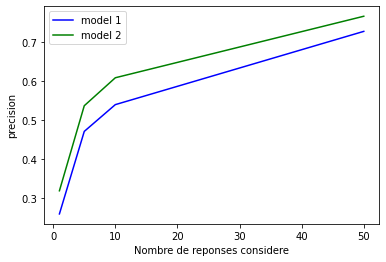

In [ ]:
N = [1,5,10,50]
plt.xlabel("Nombre de reponses considere")
plt.ylabel("precision")
plt.plot(N, [ e/validation_data_size for e in m1e.values()], color="blue", label="model 1", markersize=12)
plt.plot(N, [ e/validation_data_size for e in m2e.values()], color="green", label="model 2", markersize=12)
plt.legend()
plt.show()

3. (_5 points_) A cette étape, vous devez produire un fichier _passage_submission_M1.csv_ et _passage_submission_M2.csv_ qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre modèle M1 et M2 pour y répondre. C’est à vous de déterminer si vous utiliserez la distance euclidienne ou cosinus basé sur vos résultats d’évaluation sur l’ensemble de validation en 1) et 2). Le fichier doit respecter le format suivant pour chaque top_N(N=1,5,10,50) :  <QuestionID, PassageID1 ;… ;PassageIDN>. Le format est démontré dans _sample_passage_submission.csv_.

In [ ]:
test_data = pd.read_csv(PATH+"test.csv")

In [ ]:
questions_minuscule_test = transform_min(test_data["question"])
questions_cleaned_test = questions_minuscule_test.apply(clean_data)

questions_test_str = questions_cleaned_test.apply(lambda x: " ".join(x))

tfidf_questions_test_model1 = vectorizer_model1.transform(questions_test_str)
tfidf_questions_test_model2 = vectorizer_model2.transform(questions_test_str)

In [ ]:
def top_n(ids, questions, paragraphs, dist, n):
  tops = []
  for index, id in ids.items():
    all_distances_for_row = distances_per_question(questions[index], paragraphs, dist, 50)
    top = {}
    top["id"] = id
    top["1"] = all_distances_for_row[0]
    top["5"] = ";".join(str(e) for e in all_distances_for_row[0:5])
    top["10"] = ";".join(str(e) for e in all_distances_for_row[0:10])
    top["n"] = ";".join(str(e) for e in all_distances_for_row[0:n])
    tops.append(top)
  return tops

In [ ]:
top_n_m1 = top_n(test_data["id"],tfidf_questions_test_model1, tfidf_paragraphs_model1, euclidean_distances, 50)

KeyboardInterrupt: 

In [ ]:
df1 = pd.DataFrame(top_n_m1)
df1.to_csv("passage_submission_M1.csv")

In [ ]:
top_n_m2 = precision(test_data["id"],tfidf_questions_test_model2, tfidf_paragraphs_model2, euclidean_distances, 50)

In [ ]:
df2 = pd.DataFrame(top_n_m2)
df2.to_csv("passage_submission_M2.csv")

### 5.5. Le plus (24 points)

1. (_21 points_) Vous devez proposer un modèle M3 différent (basé sur l’apprentissage machine par exemple) afin de déterminer un score de pertinence d’un passage pour une question donnée et ordonner les passages. 
    - Faites une petite recherche sur l’état de l’art en consultant https://nlp.stanford.edu/IR-book/information-retrieval-book.html
    - Vous êtes libres de proposer une autre métrique de poids, ou une autre façon d’ordonner les passages (exemple : méthodes de type _learning to rank_) et de partir de votre corpus initial ou de votre ordonnancement en M1/M2 (choisissez le meilleur) et de réordonnancer les passages obtenus par votre premier modèle.
    - Expliquez votre modèle et son intérêt dans votre notebook. Le nombre de points obtenus dépendra de l’effort mis dans cette partie.

## Explication de ce que allons faire

<br>

Nous allons utiliser plusieurs modèles de langage naturel connus pour répondre à l'objectif de pouvoir associé le bon extrait de paragraphe à la bonne question. De plus, nous allons expliquer comment est-ce que les différents modèles fonctionnent.

<br>

Les différents modèles que nous allons explorer sont les suivants :
- word2vec
- fastText

<br>

### Traitement des données : 

<br>

In [ ]:
import gensim

corpus_paragraphs = pd.read_csv(PATH + "corpus.csv")["paragraph"]
corpus_cleaned = clean_data(corpus_paragraphs)


In [ ]:
#training data processing
train_df = pd.read_csv(PATH + "train_ids.csv")
train_questions = train_df["question"]
train_paragraphs = train_df["paragraph_id"].apply(lambda x : corpus_paragraphs[x])

train_cleaned_questions = clean_data(train_questions)
train_cleaned_paragraphs = clean_data(train_paragraphs)

#validation data processing
val_df = pd.read_csv(PATH + "val_ids.csv")
val_questions = val_df["question"]
val_cleaned_questions = clean_data(val_questions)

corpus_cleaned_unique = clean_data(pd.Series(corpus_paragraphs.unique()))
all_vocab = corpus_cleaned_unique.to_list() + train_cleaned_questions.to_list() + val_cleaned_questions.to_list()

### Fonctions communes :

In [ ]:
def vectorize(sentence, model):
    ans = []
    for word in sentence:
        if model.wv.has_index_for(word):
            ans.append(model.wv[word])
    if(len(ans) == 0):
        return np.array([np.zeros(200)])
    return np.array(ans)

def vectorize_sentence(processed_data, model):
    vec_data = processed_data.apply(lambda sentence : vectorize(sentence, model))
    vec_data_sentence = vec_data.apply(lambda x : np.mean(x ,axis = 0) if len(x) != 1 else x[0])
    return np.stack(vec_data_sentence.values)

    


### word2vec

<br>

##### L'intuition derrière word2vec

Un word2vec est un modèle d'apprentissage machine qui possède 2 couches de neuronnes. Ce modèle va essayer d'apprendre comment construire un espace vectoriel où chaque mot qui est définie dans le vocabulaire du modèle est représenté comme un vecteur. Des mots tels que chats et chien devraient, donc avoir une distance entre eux assez basse vu que ce sont des mots qui se ressemble relativement beaucoup (ces mots représente des animaux domestiques qui sont à peu près de même taille). 

<br>

Le modèle apprends à faire le plongement linguistique en mettant en relation les différents mots avec leur contexte. Ceci veut dire qu'un mot qui partage souvent un contexte similaire à un autre va se trouver à être d'une signification similaire pour le modèle. C'est important de comprendre cela, car cela vient expliquer pourquoi, pour qu'un mot soit compris par le modèle, il faut réellement qu'il puisse avoir été vu lors de la phase d'entrainement. Cela est du au fait que sinon le mot aura de la misère à se trouver une place dans l'espace vectoriel.

<br>

##### Comment ça fonctionne mathématiquement ?

Dans le contexte de cette explication, nous allons expliquer que comment CBOW fonctionne vu que Skip-Gram n'a pas été utilisé dans le code. De plus, je ne vais pas rentrer extrêmement dans le détail de comment le modèle fait pour apprendre, mais je vais, toutefois, vous donner une idée générale de la procédure à suivre pour l'implémenter. 

Le modèle CBOW (acronyme pour "Continuous Bag or Words") va apprendre la valeur vectorizé de chaque mot en essayant de prédire un mot lorsqu'on lui donne le contexte qui entoure ce mot. Pour ce faire, nous allons attribuer aux différents mots un vecteur aléatoire et, ensuite, faire de l'apprentissage supervisé se basant sur une descente en gradient pour ajuster les poids du réseaux de neuronnes. 
Voici certaines informations en ce qui attrait à l'implémentation :

- Loss Function : Logarithmic loss
- Activation Function : Softmax
- Backward Propagation Formulas can be found at this link : https://srishtee-kriti.medium.com/mathematics-behind-continuous-bag-of-words-cbow-model-1e54cc2ecd88 

<br>
<h3><center>Archictecture CBOW</center></h3>

![image.png](https://miro.medium.com/max/604/1*DfuBd49nCtT99h328iXL2Q.png)


In [ ]:
from gensim.models import Word2Vec

#train the word2vec model
word2vec_model = Word2Vec(all_vocab, vector_size = 200)


In [ ]:
#vectorize the data
print("Starting the vectorization of the data word2vec")
train_vec_paragraphs_sentence = vectorize_sentence(train_cleaned_paragraphs, word2vec_model)
train_vec_questions_sentence = vectorize_sentence(train_cleaned_questions, word2vec_model)


In [ ]:
# NE PAS RUN -- PRENDS BEAUCOUP DE TEMPS À APPRENDRE -- RUN LA PROCHAINE POUR RUN CELUI QUI FUT ENTRAINÉ

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from joblib import dump

regressor = SVR(gamma='auto')
SVR_word2vec = MultiOutputRegressor(regressor, n_jobs = 1)
SVR_word2vec.fit(train_vec_questions_sentence[:10000, ], train_vec_paragraphs_sentence[:10000, ])
dump(SVR_word2vec, 'SVR_word2vec_trained.joblib')


In [ ]:
from joblib import load
SVR_word2vec = load('SVR_word2vec_trained.joblib')

#validation  
val_vec_questions_sentence_word2vec = vectorize_sentence(val_cleaned_questions, word2vec_model)


### FastText

<br>

Tout comme Word2Vec, l'algorithme fasttext va essayer de trouver une représentation vectorielle des mots dans le vocabulaire. Toutefois, la manière dont il va le faire est complètement différente. FastText va faire un n-gramme de lettres pour donner du sens au différents mots qui se trouve dans le vocabulaire. 

<br>


In [ ]:
from gensim.models import FastText

fasttext_model = FastText(all_vocab, vector_size = 200, window=5)


In [ ]:
#vectorize the data
print("Starting the vectorization of the data fasttext")
train_vec_paragraphs_fasttext = vectorize_sentence(train_cleaned_paragraphs, fasttext_model)
train_vec_questions_fasttext = vectorize_sentence(train_cleaned_questions, fasttext_model)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from joblib import dump

regressor = SVR(gamma='auto')
SVR_fasttext = MultiOutputRegressor(regressor, n_jobs = 1)
SVR_fasttext.fit(train_vec_questions_fasttext[:10000, ], train_vec_paragraphs_fasttext[:10000, ])
dump(SVR_fasttext, 'SVR_fasttext_trained.joblib')


In [ ]:
from joblib import load
SVR_word2vec = load('SVR_fasttext_trained.joblib')

#validation  
val_vec_questions_sentence_fasttext = vectorize_sentence(val_cleaned_questions, fasttext_model)

### Liens de références

1. https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469
2. https://israelg99.github.io/2017-03-23-Word2Vec-Explained/
3. https://kavita-ganesan.com/fasttext-vs-word2vec/#.YUf3C7hKiUk
4. https://srishtee-kriti.medium.com/mathematics-behind-continuous-bag-of-words-cbow-model-1e54cc2ecd88
5. https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3
6. https://medium.com/analytics-vidhya/how-i-build-a-question-answering-model-3548878d5db2




2. (_2  point_) Vous devez ensuite afficher l’évaluation de votre modèle M3 tel que décrit dans la section 5.4 Evaluation en utilisant les mêmes fonctions. Notamment, vous devez comparer les performances de vos modèles M1, M2 et M3 sur l’ensemble de validation avec une courbe de performance faisant varier le N (N=1, 5, 10, …)

In [ ]:
def precision(data, vec_questions, vec_paragraphs, clf, n = 1, dist = euclidean_distances):
  nbr = 0
  for index, row in data.iterrows():
    predicted_paragraph = clf.predict(vec_questions[index].reshape(1, -1))
    predictions = distances_per_question(predicted_paragraph, vec_paragraphs,euclidean_distances, n)
    if row["paragraph_id"] in predictions:
      nbr += 1
  return nbr / data.shape[0]

In [ ]:
corpus_vec_paragraphs_sentence_word2vec = vectorize_sentence(corpus_cleaned, word2vec_model)

In [ ]:
# word2vec eucledian
print("Started word2vec eucledian")
ns = [50]
for n in ns:
    print(precision(val_df, val_vec_questions_sentence_word2vec, corpus_vec_paragraphs_sentence_word2vec, SVR_word2vec, n = n))
print("Done !")


In [ ]:
# word2vec cosine similarity
print("Started word2vec cosine similarity")
ns = [50]
for n in ns:
    print(precision(val_df[:100], val_vec_questions_sentence_word2vec[:100], corpus_vec_paragraphs_sentence_word2vec, SVR_word2vec, n = n, dist = cosinus_distances_per_question))
    
print("Done !")

In [ ]:
corpus_vec_paragraphs_sentence_fasttext = vectorize_sentence(corpus_cleaned, fasttext_model)

In [ ]:
# fasttext eucledian
print("Started fasttext eucledian")
ns = [50]
for n in ns:
    print(precision(val_df[:100], val_vec_questions_sentence_fasttext[:100], corpus_vec_paragraphs_sentence_fasttext, SVR_fasttext, n = n))
print("Done !")


In [ ]:
# fasttext cosine similarity
print("Started fasttext eucledian")
ns = [50]
for n in ns:
    print(precision(val_df[:100], val_vec_questions_sentence_fasttext[:100], corpus_vec_paragraphs_sentence_fasttext, SVR_fasttext, n = n, dist = cosinus_distances_per_question))
print("Done !")

### Explication des résultats

Les résultats pourraient sembler relativement mauvais comparément aux résultats au TF-IDF, mais le SVR c'est fait entrainer avec seulement 1/8 des données étant donné que le temps d'entrainement prennait beaucoup de temps. Ceci explique pourquoi est-ce que les résultats sont plus bas. Prenant ceci en considération, les résultats sont assez impressionnants.

<br>

3. (_1 point_) En utilisant votre modèle M3, vous devez produire un fichier passage_submission_M3.csv qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre système pour y répondre. Le fichier doit respecter le format suivant pour chaque top_N (N=1,5,10,50) :  <QuestionID, PassageID1…PassageIDN>. _Le format est démontré dans sample_passage_submission.csv_

In [ ]:
test_data = pd.read_csv(PATH+'test.csv')
test_cleaned = clean_data(test_data["question"])
test_vec = vectorize_sentence(test_cleaned, word2vec_model)

In [ ]:
print("starting")
ns = [1, 5, 10]

ans = []
print(test_data.shape)
for index, row in test_data.iterrows():
    predicted_paragraph = SVR_word2vec.predict(test_vec[index].reshape(1, -1))
    predictions = distances_per_question(predicted_paragraph, corpus_vec_paragraphs_sentence_word2vec,euclidean_distances, ns[-1])
    str_predictions = list(map(str, predictions))
    ans.append([';'.join(str_predictions[:n]) for n in ns])
    
print("Starting the save !")
pd.DataFrame(ans).to_csv('submission.csv', header = ["top_{}".format(n) for n in ns], index_label = "id")

    

## LIVRABLES
Vous devez remettre sur Moodle:
1. _Le code_ : Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source_. Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles ; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires ;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié ;
4. Les fichiers de soumission de données de test _passage_submission_M1.csv_ et _passage_submission_M2.csv_
5. Un document _contributions.txt_ : Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance correcte des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- Règle 1:  Le plagiat de code est bien évidemment interdit.
- Règle 2: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- Règle 3:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
